### **Класифікація зображень надзвичайних ситуацій (пошкоджень) за допомогою ResNet-18 (PyTorch)**

Аерофото надзвичайних ситуацій були зібрані з різних онлайн-джерел (наприклад, зображень Google, зображень Bing, YouTube, веб-сайтів новинних агентств тощо) з використанням ключових слів «Вид з повітря», «БПЛА» або «Дрон» та таких подій, як пожежа або задимлення, повінь, обвалення або руйнування будівлі та дорожньо-транспортна пригода. При цьому використовуються також зображення без негативних подій - звичайна ситуація.

**Ключові особливості скрипта**

_Завантаження та розпакування_:
- використовує requests для завантаження AIDER.zip з наданого посилання та
- zipfile для розпакування в локальну директорію.

_Підготовка даних_:
- будує структурований датасет з 5 класами (traffic_incident, collapsed_building, fire, flooded_areas, normal);
- ділить дані на train/val/test з урахуванням дисбалансу,
- готує трансформації та DataLoaders.

_Класифікація_:
- містить приклад швидкої базової моделі класифікації на PyTorch (transfer learning, ResNet18),
- додає baseline-метрики й збереження найкращої моделі,
- надає точки розширення для детекції/сегментації (як стартову структуру).

_Вимоги_: за потреби встановіть залежності `# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121`

### **Налаштування**

In [1]:
# Рекомендований спосіб для M1/M2 Mac
# pip install torch torchvision torchaudio

# Для CPU only (будь-яка система):
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# Для Windows/Linux з NVIDIA GPU:
# CUDA 11.8
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# CUDA 12.1
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import os
import requests
import zipfile
import shutil
import random
from pathlib import Path
from typing import Tuple, List, Dict

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE =torch.device("cpu")

print(f"Використовується пристрій: {DEVICE}")

Використовується пристрій: cpu


### **Дані**

In [ ]:
# Завантаження та розпакування AIDER.zip

root = Path("./Data") # Це – для роботи з файлами та папками.
root.mkdir(parents=True, exist_ok=True)  # "створити папку" (make directory).
                                         # parents=True – якщо потрібно, вказати весь шлях
                                         # exist_ok=True не кидатиме помилку, якщо така тека вже є.

file = 'AIDER.zip'
url = 'https://zenodo.org/records/3888300/files/' + file  # офіційне джерело

extracted_path = 'AIDER'
zip_path = root / file # Місце, куди збережемо файл архіву.
data_dir = root / extracted_path  # Папка, куди потім розпаковуватимемо

print(f"📁 Робоча директорія: {root}")
print(f"📦 Шлях до архіву: {zip_path}")
print(f"📂 Шлях до даних: {data_dir}")

📁 Робоча директорія: Data
📦 Шлях до архіву: Data/AIDER.zip
📂 Шлях до даних: Data/AIDER


In [ ]:
# Перевірка, чи файл AIDER.zip або папка AIDER уже є в вказаній папці
# Якщо ні, відбудеться завантаження zip-файла
if not zip_path.exists() and not data_dir.exists():
    print("Downloading AIDER.zip ...")
    with requests.get(url,      # HTTP-запит на завантаження
                      stream=True) as r:  # stream=True – “завантажуй потоково”, тобто по частинах, не завантажуючи весь файл у пам’ять
        r.raise_for_status()    # Підніме помилку, якщо сервер повернув код 4xx/5xx
        with open(zip_path, "wb") as f:   # Відкриває файл для запису в двійковому режимі ("wb").
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
                # Читає відповідь невеликими порціями по ~8 КБ і одразу записує на диск
else:
    print("AIDER.zip already exists.")

if not data_dir.exists():
    print("Extracting AIDER.zip ...")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(root)
    # Якщо архів витягнувся в поточну папку без вкладеної "AIDER", нормалізуємо шлях:
    # чекаємо структуру з 5 папками: traffic_incident, collapsed_building, fire, flooded_areas, normal
    # Якщо файли опинилися в root, перенесемо в data_dir
    expected_classes = {"traffic_incident","collapsed_building","fire","flooded_areas","normal"}
    present = {p.name for p in root.iterdir() if p.is_dir()}
    if expected_classes.issubset(present):
        data_dir.mkdir(exist_ok=True)
        for cls in expected_classes:
            shutil.move(str(root/cls), str(data_dir/cls))
else:
    print("AIDER already extracted.")

print("Extracted folders:", [p.name for p in data_dir.iterdir() if p.is_dir()])

AIDER.zip already exists.
Extracting AIDER.zip ...
Extracted folders: ['traffic_incident', 'collapsed_building', 'normal', 'fire', 'flooded_areas']


Після розпакування всередині повинні бути каталоги: `traffic_incident`, `collapsed_building`, `fire`, `flooded_areas`, `normal` з відповідними .jpg-файлами, як описано у завданні (наприклад, traffic_incident_image0001.jpg … traffic_incident_image0485.jpg, normal_image0001.jpg … normal_image4390.jpg).

In [ ]:
class_names = ['collapsed_building', 'fire', 'flooded_areas', 'normal', 'traffic_incident']

### **Формування списку зразків та розбиття train/val/test**

Ми зробимо стратифікований спліт у пропорціях 70%/15%/15% на рівні зображень. Для дисбалансу застосуємо аугментації + class_weight.

In [ ]:
all_samples = []    # порожній список
for cls_idx, cls in enumerate(class_names):     # проходимо всі назви класів. enumerate дає:
                                                # cls_idx: числовий індекс класу (0, 1, 2, …),
                                                # cls: назва класу як рядок (наприклад, "fire").
    files = sorted((data_dir/cls).glob("*.jpg")) # беремо всі .jpg у цій папці та впорядковуємо
    for fp in files:  # Для кожного файлу додаємо словник з 3 полями:
        # "path": повний шлях до зображення як рядок,
        # "label": числовий індекс класу (зручно для моделі),
        # "class": назва класу людиною-зрозуміло.
        all_samples.append({"path": str(fp), "label": cls_idx, "class": cls})

# Перетворюємо список у DataFrame
df = pd.DataFrame(all_samples)
df.head(), df["class"].value_counts()

# Стратифіковане розбиття на train/val/test
train_df, temp_df = train_test_split(
    df, test_size=0.30,
    stratify=df["label"], # Гарантує, що пропорції класів у train і temp збережуться такими ж, як у df
    random_state=SEED
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["label"], random_state=SEED
)

print('Довжина train, val і test наборів:', len(train_df), len(val_df), len(test_df) )
print('Розподіл класів по наборах:')
display(pd.concat( [train_df["class"].value_counts(normalize=True),
        val_df["class"].value_counts(normalize=True),
        test_df["class"].value_counts(normalize=True)], axis=1, keys=['train', 'val', 'test'])
        )

Довжина train, val і test наборів: 4503 965 965
Розподіл класів по наборах:


,train,val,test
class,,,
normal,0.682434,0.682902,0.681865
flooded_areas,0.081723,0.081865,0.081865
fire,0.081057,0.080829,0.080829
collapsed_building,0.079503,0.078756,0.079793
traffic_incident,0.075283,0.075648,0.075648


### **Трансформації та Dataset/DataLoader**

Це – код для обробки зображень у PyTorch, який зазвичай використовується для підготовки даних перед навчанням нейронних мереж. Завдяки йому створюються два набори трансформацій (перетворень) для зображень:
* `train_tfms` - для навчальних даних (з додатковою аугментацією)
* `val_test_tfms` - для валідаційних і тестових даних (без аугментації)

Зазначимо, що:
* `transforms` — це модуль torchvision, який містить готові перетворення зображень;
* `transforms.Compose([...])` — “конвеєр”, якмй застосовує список перетворень послідовно зліва направо до кожного зображення.

При цьому маємо два набори перетворень:
* `train_tfms` (для тренування): містить аугментації — випадкові зміни зображень, щоб модель стала більш стійкою до поворотів, дзеркал, змін освітлення тощо.
* `val_test_tfms` (для валідації/тесту): лише детермінальні перетворення (без випадковостей), щоб чесно і однаково оцінювати якість моделі.

IMG_SIZE = 224 – цільовий розмір зображення по кожній стороні: 224×224 пікселів. Це – Це популярний розмір для багатьох предтренованих (попередньо навчених) моделей комп'ютерного зору таких, як ResNet, EfficientNet тощо.

`transforms.Resize((IMG_SIZE, IMG_SIZE))` змінює розмір будь-якого вхідного зображення до 224×224. Так потрібно, бо нейромережі очікують однаковий розмір на вході.

`transforms.RandomHorizontalFlip(p=0.5)` [лише в train] – випадкове горизонтальне віддзеркалення з ймовірністю 50%. Допомагає моделі не “прив’язуватись” до ліво/право орієнтації сцени.

`transforms.RandomRotation(10)` [лише в train]
Випадковий поворот на кут у діапазоні [-10°, +10°].
Пом’якшує чутливість до невеликих нахилів камери.

`transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05)` [лише в train] – з метою створення моделі менш чутливою до освітлення/кольору. випадково змінює:
* яскравість у межах ±15%,
* контраст у межах ±15%,
* насиченість у межах ±15%,
* відтінок hue у межах ±0.05 (це частка від допустимого діапазону hue; 0.05 — помірна зміна).

`transforms.ToTensor()`:
* перетворює PIL-зображення або NumPy-масив у тензор PyTorch формату C × H × W (канали × висота × ширина).
* нормалізує діапазон значень з [0, 255] до [0, 1] типу float32. Приклад: зображення 224×224×3 стає тензором розміру 3×224×224.

`transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])` канально нормалізує тензор: x_norm = (x - mean) / std для кожного з трьох каналів (RGB). Це – статистики з ImageNet. Якщо ви використовуєте предтреновані моделі (ResNet, EfficientNet із torchvision), саме ці mean/std очікуються і забезпечують коректну шкалу ознак. Якщо тренуєте модель “з нуля”, теж можна використовувати ці значення або обчислити середні/стандарти від вашого датасету.

In [ ]:
IMG_SIZE = 224

train_tfms = transforms.Compose([    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

val_test_tfms = transforms.Compose([    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

Нижче список файлів “загортається” у PyTorch‑датасет, а потім подається у модель батчами через DataLoader.

`AIDERDataset(Dataset)` – це спеціальний клас для роботи з набором даних зображень. Він наслідується від базового класу Dataset з бібліотеки PyTorch. Є обгорткою над pandas DataFrame, яка каже PyTorch, як отримати i‑тий зразок.

* `init(self, df, transform=None)` - метод ініціалізації
    * `df` — таблиця з даними. У ній, як мінімум, мають бути колонки:
        * `path` — повний шлях до зображення (рядок).
        * `label` — числовий індекс класу (int).
    * `transform` — пайплайн перетворень (аугментації/нормалізації) з `torchvision.transforms`; застосовується до кожного зображення.
    * `self.df = df.reset_index(drop=True)` скидає старі індекси, щоб позиції 0..N-1 відповідали рядкам.
* `len(self)` повертає кількість рядків у `df`. PyTorch використовує це, щоб знати розмір датасету.
* `getitem(self, idx)`:
    * Дістає рядок df з позиції idx: `row = self.df.iloc[idx]`.
    * Завантажує зображення: `Image.open(row["path"]).convert("RGB")`
        * `PIL` відкриває файл;
        * `.convert("RGB")` гарантує 3 канали (навіть якщо файл був у градаціях сірого).
    * Якщо задано `transform`, застосовуємо його до img. Зазвичай `transform` перетворює PIL‑картинку на тензор, змінює розмір, нормалізує тощо.
    * Беремо мітку класу: `label = int(row["label"])`.
    * Повертаємо кортеж `(img, label)`.
        * `img` — тензор `torch.FloatTensor` розміру [C, H, W] після трансформацій.
        * `label` — int (для `CrossEntropyLoss`).

In [ ]:
class AIDERDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(row["label"])
        return img, label

In [ ]:
# Створення датасетів, застосовуючи різні трансформації:
# train_tfms — з аугментаціями (flip/rotation/color jitter) + ToTensor + Normalize: допомагає моделі узагальнювати.
# val_test_tfms — тільки детермінальні кроки (Resize, ToTensor, Normalize), без випадковостей, щоб чесно міряти якість.

train_ds = AIDERDataset(train_df, transform=train_tfms)
val_ds   = AIDERDataset(val_df,   transform=val_test_tfms)
test_ds  = AIDERDataset(test_df,  transform=val_test_tfms)

# DataLoader’и: як подавати дані в модель батчами
BATCH_SIZE = 32     # скільки зображень у одній порції
NUM_WORKERS = 2 if os.name == "nt" else 4   # скільки фонових процесів читають і готують дані паралельно.
                                            # 2 процеси для Windows (os.name == "nt"); 4 – для Linux/Mac.

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# DataLoader - це "конвеєр", який бере фото зі "складу", групує їх по 32 штуки в "коробки" та відправляє на обробку нейронній мережі:
# shuffle=True (для train_loader) - перемішує дані кожну епоху навчання
# shuffle=False (для val/test) - зберігає порядок для стабільності результатів
# pin_memory=True - пришвидшує передачу даних на відеокарту (GPU)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### **Балансування: ваги класів** (опціонально)

Оскільки клас normal значно більший, можемо задати ваги втрат.

In [ ]:
class_counts = train_df["label"].value_counts().sort_index().values
class_counts

# Інверсія частот як прості ваги
class_weights = torch.tensor((1.0 / (class_counts / class_counts.max())), dtype=torch.float32).to(DEVICE)
class_weights

tensor([8.5838, 8.4192, 8.3505, 1.0000, 9.0649])

### **Модель класифікації (ResNet18, transfer learning)**

Далі реалізовано підхід **transfer learning** (перенесення навчання) з використанням попередньо навченої нейронної мережі ResNet18.
Цей підхід означає, що замість навчання моделі з нуля, ми беремо модель, яка вже навчена на великому наборі даних, і адаптуємо її до нашої задачі. Це як навчити людину, яка вже вміє грати на гітарі, грати на укулеле - базові навички вже є, потрібно лише адаптуватися.

**ResNet18** - це популярна архітектура нейронної мережі для розпізнавання зображень. Число 18 означає, що мережа має 18 шарів. Модель вже навчена на величезному наборі даних ImageNet (містить мільйони зображень з 1000 категорій), тому вона вже "вміє" виділяти корисні ознаки з зображень.

Переудомовою реалізації цього підходу є відповідність трансформацій ImageNet: Resize до 224×224, Normalize mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225].

Ще варто зазначити, що підхід здійснює **часткове розморожування**:
* Базові шари (layer1-3) залишаються замороженими - вони виділяють прості ознаки
* Останній блок (layer4) розморожується - адаптується до специфіки задачі
* Новий класифікатор (fc) навчається з нуля

In [ ]:
num_classes = len(class_names)      # кількість класів

# Завантаження попередньо навченої моделі
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Заморожування фіч. Заморожування означає, що ми забороняємо оновлювати ваги (параметри)
# більшості шарів мережі під час навчання. Це робиться з двох причин:
#   1) Швидкість: навчання відбувається набагато швидше
#   2) Збереження знань: ми зберігаємо корисні ознаки, які модель вже навчилася виділяти
for p in model.parameters():
    p.requires_grad = False

# Розморожування останнього блоку.
# Тут ми розморожуємо останній блок (layer4) мережі. Це дозволяє моделі адаптувати глибші, більш абстрактні ознаки
# до нашої конкретної задачі, зберігаючи при цьому базові ознаки (краї, текстури) незмінними.
for p in list(model.layer4.parameters()):
    p.requires_grad = True

# Заміна останнього шару
# Оригінальна модель ResNet18 була навчена на 1000 класів ImageNet. Ми замінюємо останній шар (fully connected layer),
# щоб він видавав потрібну нам кількість класів. Новий шар буде навчатися з нуля.
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# Налаштування для навчання
model = model.to(DEVICE)    # Вибір обчислювального пристрою
criterion = nn.CrossEntropyLoss(weight=class_weights) # Функція втрат
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4) # Оптимізатор
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2) # Планувальник. Автоматично
                                                                 # зменшує швидкість навчання, якщо модель перестає покращуватися

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


### **Тренування і валідація**


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return total_loss/total, total_correct/total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        logits = model(imgs)
        loss = criterion(logits, labels)
        total_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum().item()
        total += imgs.size(0)
        all_labels.extend(labels.cpu().tolist())
        all_preds.extend(preds.cpu().tolist())
    return total_loss/total, total_correct/total, np.array(all_labels), np.array(all_preds)

best_val_acc = 0.0
best_path = "best_resnet18_aider.pt"
EPOCHS = 10

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
    scheduler.step(val_acc)
    print(f"Epoch {epoch:02d}: train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({"model": model.state_dict(), "classes": class_names}, best_path)
        print("Saved new best model.")

Epoch 01: train_loss=0.3597 train_acc=0.8494 | val_loss=0.2024 val_acc=0.9244
Saved new best model.
Epoch 02: train_loss=0.1733 train_acc=0.9214 | val_loss=0.2561 val_acc=0.9461
Saved new best model.
Epoch 03: train_loss=0.1014 train_acc=0.9549 | val_loss=0.2872 val_acc=0.9430
Epoch 04: train_loss=0.0894 train_acc=0.9567 | val_loss=0.2599 val_acc=0.9523
Saved new best model.
Epoch 05: train_loss=0.0604 train_acc=0.9725 | val_loss=0.2117 val_acc=0.9596
Saved new best model.
Epoch 06: train_loss=0.0432 train_acc=0.9809 | val_loss=0.4422 val_acc=0.9513
Epoch 07: train_loss=0.0636 train_acc=0.9705 | val_loss=0.2910 val_acc=0.9554
Epoch 08: train_loss=0.0297 train_acc=0.9838 | val_loss=0.3421 val_acc=0.9575
Epoch 09: train_loss=0.0240 train_acc=0.9896 | val_loss=0.3116 val_acc=0.9617
Saved new best model.


### **Оцінка на тесті**

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test loss=0.1694, Test acc=0.9720

Classification report:

                    precision    recall  f1-score   support

collapsed_building     0.9487    0.9610    0.9548        77
              fire     0.9750    1.0000    0.9873        78
     flooded_areas     0.9494    0.9494    0.9494        79
            normal     0.9877    0.9772    0.9824       658
  traffic_incident     0.8831    0.9315    0.9067        73

          accuracy                         0.9720       965
         macro avg     0.9488    0.9638    0.9561       965
      weighted avg     0.9725    0.9720    0.9722       965



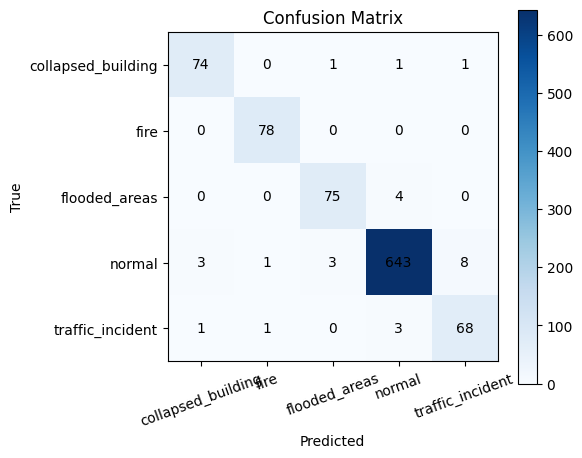

In [ ]:
# Завантажимо найкращу модель
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model"])

test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion)
print(f"Test loss={test_loss:.4f}, Test acc={test_acc:.4f}")

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Матриця плутанини
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=20)
plt.yticks(ticks=range(len(class_names)), labels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()

### **Прогноз 1-го зображення**

In [ ]:
#import os
#import torch
#import numpy as np
#import matplotlib.pyplot as plt
#from PIL import Image

# 1) Пристрій
#DEVICE = torch.device("mps" if torch.backends.mps.is_available()
#                      else ("cuda" if torch.cuda.is_available() else "cpu"))
#print("Using:", DEVICE)

# 2) Завантаження найкращої моделі і класів
best_path = "best_resnet18_aider.pt"  # ваш шлях до чекпойнта
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model"])       # model — ваш ResNet18, уже створений
model.to(DEVICE).eval()

# Якщо у чекпойнті збережено список класів — беремо саме його (щоб порядок точно збігався з тренуванням)
if "classes" in ckpt:
    class_names = ckpt["classes"]
num_classes = len(class_names)
print("Classes:", class_names)

# 3) Переконаймося, що є валідні трансформації для інференсу (як на валідації/тесті)
# Якщо у вас вже є val_test_tfms — використовуємо його. Інакше розкоментуйте блок ниже:
# from torchvision import transforms
# IMG_SIZE = 224
# val_test_tfms = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
# ])

# 4) Утиліти
def infer_true_label_from_path(image_path, class_names):
    """Спроба визначити істинний клас за назвою батьківської папки (якщо структура data/CLASS/img.jpg)."""
    parent = os.path.basename(os.path.dirname(image_path))
    return parent if parent in class_names else None

@torch.inference_mode()
def predict_image(image_path: str,
                  model,
                  transform,
                  class_names,
                  true_label: str | None = None,
                  top_k: int = 5,
                  device: torch.device = DEVICE):
    """
    Робить прогноз для одного зображення, показує картинку, істинний і прогнозований класи, а також топ-K.
    """
    # Завантаження та препроцесинг (валід/тест трансформації!)
    img_pil = Image.open(image_path).convert("RGB")
    x = transform(img_pil).unsqueeze(0).to(device)   # [1, C, H, W]

    # Прогноз
    logits = model(x)
    probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()  # (num_classes,)
    pred_idx = int(probs.argmax())
    pred_name = class_names[pred_idx]
    pred_conf = float(probs[pred_idx])

    # Визначаємо істинний клас (якщо не передано явно)
    if true_label is None:
        true_label = infer_true_label_from_path(image_path, class_names)

    # Топ-K (обрізаємо до доступної кількості класів)
    k = min(top_k, len(class_names))
    top_idx = probs.argsort()[-k:][::-1]
    top_labels = [class_names[i] for i in top_idx]
    top_scores = probs[top_idx]

    # Візуалізація
    plt.figure(figsize=(12, 4))
    # Зображення
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil)
    title = f"Pred: {pred_name} ({pred_conf:.2f})"
    if true_label is not None:
        title = f"True: {true_label} | " + title
    plt.title(title)
    plt.axis("off")

    # Топ-K барчарт
    plt.subplot(1, 2, 2)
    plt.barh(range(k), top_scores[::-1], color="steelblue")
    plt.yticks(range(k), top_labels[::-1])
    plt.xlim(0, 1)
    plt.xlabel("probability")
    plt.title("Top-K probabilities")
    plt.tight_layout()
    plt.show()

    return {
        "pred_class": pred_name,
        "pred_conf": pred_conf,
        "top_labels": top_labels,
        "top_scores": top_scores.tolist(),
        "true_label": true_label
    }

Classes: ['collapsed_building', 'fire', 'flooded_areas', 'normal', 'traffic_incident']


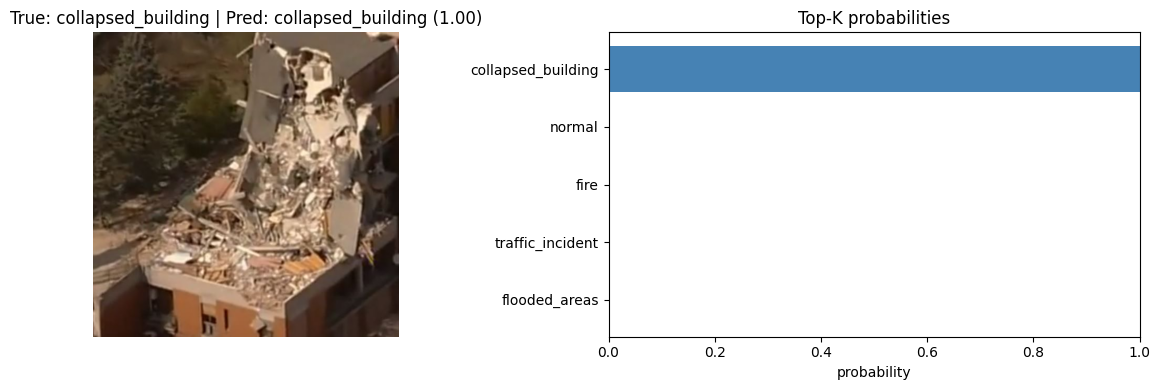

{'pred_class': 'collapsed_building',
 'pred_conf': 0.9999034404754639,
 'top_labels': ['collapsed_building',
  'normal',
  'fire',
  'traffic_incident',
  'flooded_areas'],
 'top_scores': [0.9999034404754639,
  5.32295998709742e-05,
  4.1760395106393844e-05,
  1.298061988563859e-06,
  2.5254740876334836e-07],
 'true_label': 'collapsed_building'}

In [ ]:
sample_path = "Data/AIDER/collapsed_building/collapsed_building_image0019.jpg"
res = predict_image(sample_path, model, val_test_tfms, class_names, top_k=5)
res

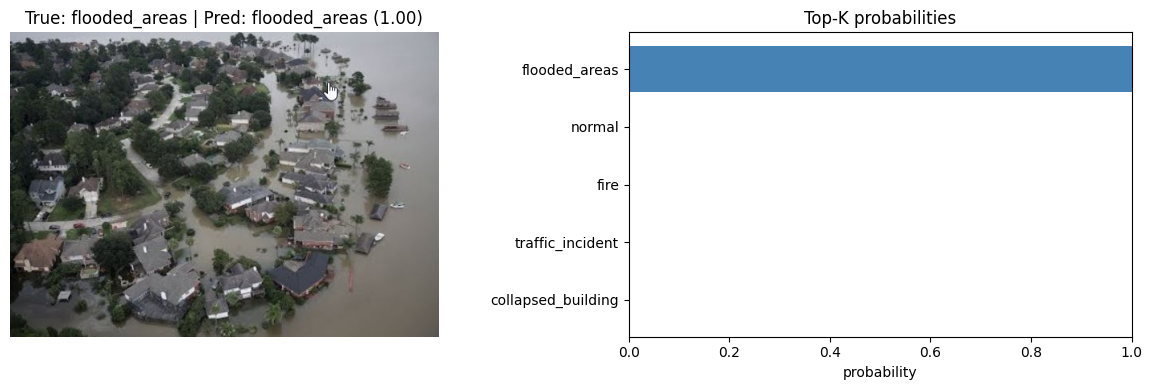

{'pred_class': 'flooded_areas',
 'pred_conf': 0.999998927116394,
 'top_labels': ['flooded_areas',
  'normal',
  'fire',
  'traffic_incident',
  'collapsed_building'],
 'top_scores': [0.999998927116394,
  1.0146891327167396e-06,
  5.4004769545201725e-09,
  1.2913765612410089e-09,
  5.347805184796606e-11],
 'true_label': 'flooded_areas'}

In [ ]:
row = test_df.sample(1, random_state=42).iloc[0]  # випадкове зображення
true_name = class_names[int(row["label"])]
res = predict_image(row["path"], model, val_test_tfms, class_names, true_label=true_name, top_k=5)
res